In [2]:
import pandas as pd
import logomaker

## 1. Analysis on d=4 for ETS1-ETS1
Since we want to get information about anticoop, I created a training data that retains all information (i.e., it includes the anticoop and fail_cutoff sequences).

In [10]:
train_ee = pd.read_csv("train_ets1_ets1_w_anticoop.tsv", sep="\t")
train_ee_d4 = train_ee[train_ee["distance"] == 4]

### 1.a. Consensus motif for d=4
It looks like ETS1-ETS1 d=4 follows a specific GGAAGGAA composite motif with differences in the flanking regions.

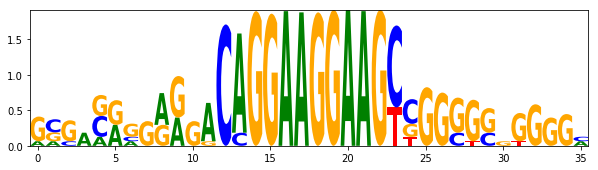

In [15]:
m = logomaker.alignment_to_matrix(train_ee_d4["Sequence"].tolist(), to_type="weight")
m[m < 0] = 0
logomaker.Logo(m)

Motifs from just the cooperative sequences are similar from the d=4 sequences in general

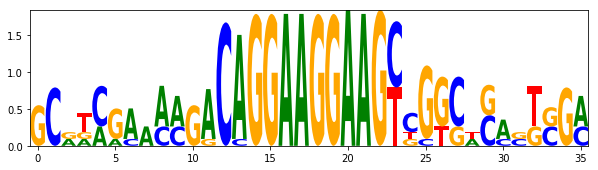

In [20]:
coop_ambiguous_seqs_d4 = train_ee_d4[train_ee_d4["label"] == "cooperative"]["Sequence"].tolist()
m = logomaker.alignment_to_matrix(coop_ambiguous_seqs_d4, to_type="weight")
m[m < 0] = 0
logomaker.Logo(m)

### 1.b. Label counts per orientation
Note that we converted all -/- into +/+

In [22]:
train_ee_d4[["orientation", "label"]].value_counts()

orientation  label          
+/+          cooperative        26
             fail_cutoff        24
             ambiguous          19
             independent        11
             anticooperative     2
-/+          ambiguous           1
+/-          fail_cutoff         1
dtype: int64

In [23]:
train_ee_d4

,Name,Sequence,label,p_o1,label_o1,p_o2,label_o2,site_str_pos,site_str_score,site_wk_pos,site_wk_score,distance,site_str_ori,site_str_core,site_wk_ori,site_wk_core,orientation
83,cistrome_ets1_37934_seq201,CGCGCCCGCTGCCCGGAAGGAAGCCGTGGGCTGGCC,cooperative,0.000246,cooperative,0.000246,cooperative,16,8.302270,20,4.050406,4,1,GGAA,1,GGAA,+/+
244,cistrome_ets1_43097_seq1734,GAGGGAGTAACACAGGAAGGAAGTGACTAGCACCAG,ambiguous,0.000246,cooperative,0.422660,independent,16,8.528399,20,8.025451,4,1,GGAA,1,GGAA,+/+
272,cistrome_ets1_43097_seq1908_0,CTCCTCCCCCATCAGGAAGGAAGTTTGTGGGTGCAC,fail_cutoff,1.000000,fail_cutoff,1.000000,fail_cutoff,20,6.928892,16,4.324332,4,1,GGAA,1,GGAA,+/+
287,cistrome_ets1_43097_seq1967,TCATCTCTCCTGCAGGAAGGAAGTCCTGCCTCCCAC,cooperative,0.000246,cooperative,0.000246,cooperative,16,6.889092,20,6.221478,4,1,GGAA,1,GGAA,+/+
427,cistrome_ets1_43097_seq3063,CAACGACTCACACAGGAAGGAAGCCCCCATCTGGTT,independent,0.873399,independent,0.042857,ambiguous,16,8.528399,20,4.050406,4,1,GGAA,1,GGAA,+/+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,cistrome_ets1_93396_seq657,AGCTAAGCAACACCGGAAGGAAGTGAGACAGAGCCT,independent,0.067488,ambiguous,0.627833,independent,16,11.379025,20,8.025451,4,1,GGAA,1,GGAA,+/+
3438,ets1_GM23338_seq261_1,GCTAAGTTGCAACAGGAAGGAAGCTGTGATTTCAAA,cooperative,0.000246,cooperative,0.000246,cooperative,16,8.528399,20,4.757820,4,1,GGAA,1,GGAA,+/+
3519,ets1_GM23338_seq600_0,AATAGACAGATCCAGGAAGGAAGCTGGGGGGCGGGT,fail_cutoff,0.000246,cooperative,1.000000,fail_cutoff,16,5.451645,20,4.757820,4,1,GGAA,1,GGAA,+/+
3520,ets1_GM23338_seq601_0,CAACAATAGACAGATCCAGGAAGGAAGCTGGGGGGC,ambiguous,0.000246,cooperative,0.422660,independent,20,5.451645,24,4.757820,4,1,GGAA,1,GGAA,+/+
